## Can the estimates from Cao-MPRA be used for prediction with OptMRL?

How are log2FC values obtained?
- DESeq2: fold change of read counts in bins relative to initial library
- read counts are normalized for library size before calculating fold change

How well do these values correlate to MRL?

How well are values between bins correlated?

How do the distributions for each bin look like?

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from Bio import Align

In [10]:
def r(x,y):
    res = linregress(x, y)
    return round(res.rvalue, 4)
    
def r2(x,y):
    res = linregress(x, y)
    return round(res.rvalue**2, 4)

#from https://gist.github.com/slowkow/06c6dba9180d013dfd82bec217d22eb5
def nw(x, y, match = 1, mismatch = 1, gap = 1):
    nx = len(x)
    ny = len(y)
    # Optimal score at each possible pair of characters.
    F = np.zeros((nx + 1, ny + 1))
    F[:,0] = np.linspace(0, -nx * gap, nx + 1)
    F[0,:] = np.linspace(0, -ny * gap, ny + 1)
    # Pointers to trace through an optimal aligment.
    P = np.zeros((nx + 1, ny + 1))
    P[:,0] = 3
    P[0,:] = 4
    # Temporary scores.
    t = np.zeros(3)
    for i in range(nx):
        for j in range(ny):
            if x[i] == y[j]:
                t[0] = F[i,j] + match
            else:
                t[0] = F[i,j] - mismatch
            t[1] = F[i,j+1] - gap
            t[2] = F[i+1,j] - gap
            tmax = np.max(t)
            F[i+1,j+1] = tmax
            if t[0] == tmax:
                P[i+1,j+1] += 2
            if t[1] == tmax:
                P[i+1,j+1] += 3
            if t[2] == tmax:
                P[i+1,j+1] += 4
    # Trace through an optimal alignment.
    i = nx
    j = ny
    rx = []
    ry = []
    while i > 0 or j > 0:
        if P[i,j] in [2, 5, 6, 9]:
            rx.append(x[i-1])
            ry.append(y[j-1])
            i -= 1
            j -= 1
        elif P[i,j] in [3, 5, 7, 9]:
            rx.append(x[i-1])
            ry.append('-')
            i -= 1
        elif P[i,j] in [4, 6, 7, 9]:
            rx.append('-')
            ry.append(y[j-1])
            j -= 1
    # Reverse the strings.
    rx = ''.join(rx)[::-1]
    ry = ''.join(ry)[::-1]
    return '\n'.join([rx, ry])

In [11]:
# import expression bins
bin1 = pd.read_excel('GSE176581_Bin_0-2.5.xlsx').rename(columns={'ensembl_gene_id':'UTR ID'})
bin2 = pd.read_excel('GSE176581_Bin_2.5-5.xlsx').rename(columns={'ensembl_gene_id':'UTR ID'})
bin3 = pd.read_excel('GSE176581_Bin_5-10.xlsx').rename(columns={'ensembl_gene_id':'UTR ID'})

#import sequences
mpralib = pd.read_excel('mpra-library-12000.xlsx').set_index('UTR ID',drop=True)

#remove oligo overhangs from mpra library sequences
mpralib['Synthesized ssDNA oligos'] = mpralib['Synthesized ssDNA oligos'].str[20:-20]
mpralib = mpralib.rename({'Synthesized ssDNA oligos':'seq'}, axis='columns')

#merge dataframes to obtain sequence and values in one df
#I assume that the ensembl_gene_id column in the bin dataframes shows the row IDs from the mpra library
bin1_lib = pd.merge(bin1, mpralib, how='inner', on='UTR ID').set_index('UTR ID',drop=True).sort_index()
bin2_lib = pd.merge(bin2, mpralib, how='inner', on='UTR ID').set_index('UTR ID',drop=True).sort_index()
bin3_lib = pd.merge(bin3, mpralib, how='inner', on='UTR ID').set_index('UTR ID',drop=True).sort_index()

In [12]:
# import list of 8414 natural sequences probed in the mpra
nat_mpra = pd.read_excel('natural-5utrs-8414.xlsx').set_index('Number',drop=True)
nat_mpra = nat_mpra.rename({'Sequence (with flanking regions)':'seq'}, axis='columns')
nat_mpra['seq'] = nat_mpra['seq'].str[20:-20]
#consider only sequences with lower transcript ID
nat_mpra = nat_mpra[:6721]
#drop transcript isoform
nat_mpra['transcript_id'] = nat_mpra['Gene'].str.split('.').str[0]

### Correlation between FACS Bins

Text(0.7, 0.1, 'R = 0.6442')

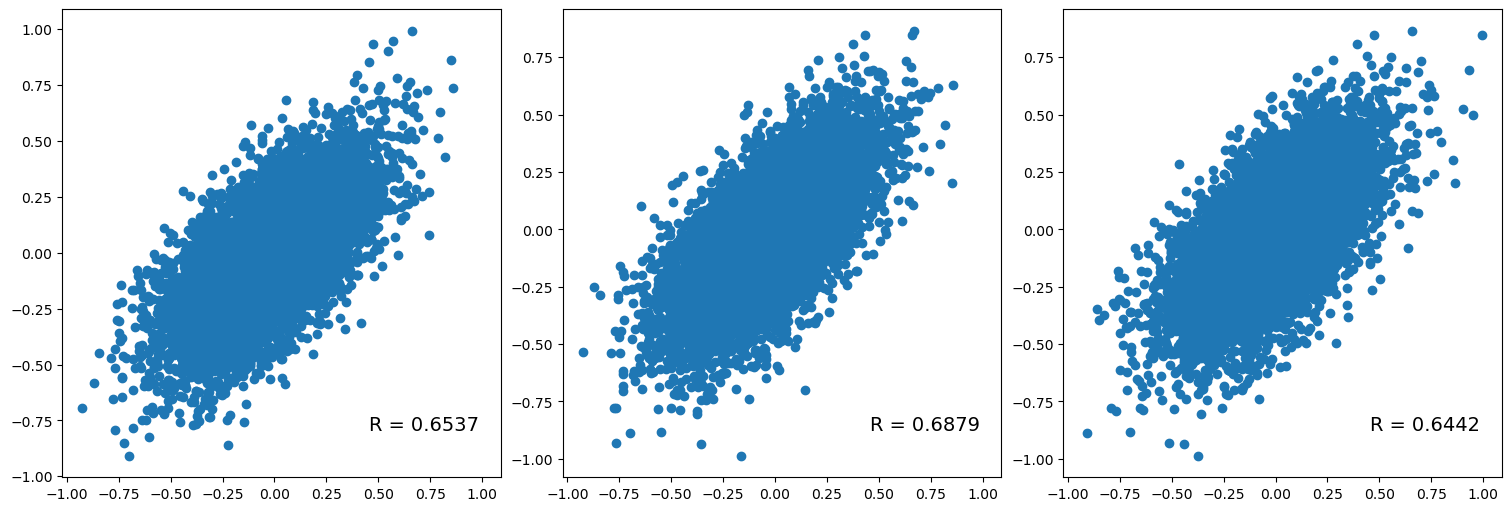

In [13]:
fig, ax = plt.subplots(1,3, layout='constrained', sharex=True, figsize=(15,5))
ax[0].scatter(bin1_lib['log2FoldChange'],bin2_lib['log2FoldChange'])
ax[0].annotate('R = %s' % r(bin1_lib['log2FoldChange'],bin2_lib['log2FoldChange']),xy=(0.7, 0.1),xycoords='axes fraction',fontsize=14)
ax[1].scatter(bin1_lib['log2FoldChange'],bin3_lib['log2FoldChange'])
ax[1].annotate('R = %s' % r(bin1_lib['log2FoldChange'],bin3_lib['log2FoldChange']),xy=(0.7, 0.1),xycoords='axes fraction',fontsize=14)
ax[2].scatter(bin2_lib['log2FoldChange'],bin3_lib['log2FoldChange'])
ax[2].annotate('R = %s' % r(bin2_lib['log2FoldChange'],bin3_lib['log2FoldChange']),xy=(0.7, 0.1),xycoords='axes fraction',fontsize=14)

### Correlation between MRL and log2FC



In [14]:
mrl = pd.read_csv('/fast/AG_Ohler/frederick/projects/mpra/mrl_te_comparison/data/GSM3130443_designed_library.csv', low_memory=False)
mrl_50 = mrl.loc[:, ['utr','rl','total','info1','info2','library']]
mrl_50 = mrl_50[mrl_50.library == 'human_utrs'].reset_index(drop=True)
mrl_50.rename(columns = {'info2':'transcript_id'}, inplace = True)
mrl_50.rename(columns = {'info1':'Gene stable ID'}, inplace = True)
#keep 25000 seqs with most reads (as in Sample et al)
mrl_50 = mrl_50.sort_values('total', ascending=False).reset_index(drop=True).iloc[:25000]

-0.0301

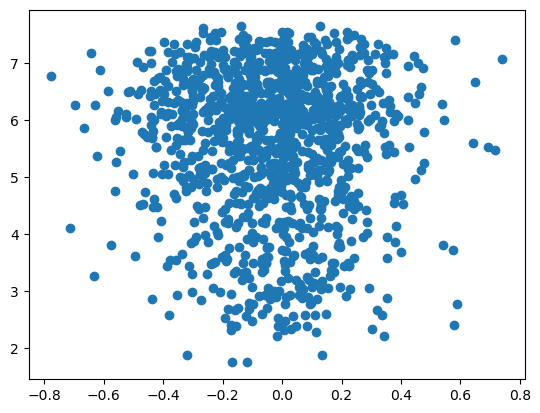

In [15]:
#merge nat_mpra and bin3 to get a df with sequence, transcript ID and log2FC
nat_mpra_bin3 = pd.merge(bin3_lib, nat_mpra, on='seq', how='inner')

#merge nat_mpra_bin3 with mrl_50 to get a df with sequence, transcript ID, log2FC and MRL
mrl_bin3 = pd.merge(nat_mpra_bin3, mrl_50, on='transcript_id', how='inner')


plt.scatter(mrl_bin3['log2FoldChange'], mrl_bin3['rl'])
r(mrl_bin3['log2FoldChange'], mrl_bin3['rl'])

-0.0307

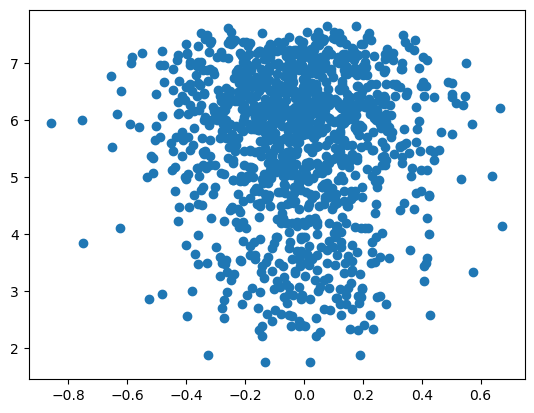

In [38]:
nat_mpra_bin2 = pd.merge(bin2_lib, nat_mpra, on='seq', how='inner')
mrl_bin2 = pd.merge(nat_mpra_bin2, mrl_50, on='transcript_id', how='inner')

plt.scatter(mrl_bin2['log2FoldChange'], mrl_bin2['rl'])
r(mrl_bin2['log2FoldChange'], mrl_bin2['rl'])

**Result** There is no correlation between the natural sequences from Cao et. al and Sample et. al. I suspect this is because of different sequences being used for the same transcript ID.

**IDEA** 
1) Apply Needleman-Wunsch pairiwse alignment to identify correctly formed pairs of sequences. To answer what proportion of the transcript_id - matched pairs is formed without gap. The following parameters will be used for NW: (match=1 mismatch=-1 gap=-10)
2) Perform global pairwise alignment and form pairs based on maximum score for NW or minimum edit distance based on other algorithms

In [17]:
#apply needleman wunsch to keep only those sequence pairs that are aligned without gap in order to determine whether it makes sense 
#to proceed to step 2 and pair sequences based on similarity instead of transcript ID

aligner = Align.PairwiseAligner()

In [30]:
print(aligner.algorithm)
aligner.open_gap_score = -5
aligner.extend_gap_score = 0

Gotoh global alignment algorithm


In [42]:
#calculate nw scores for all 
scores = []
for pair in zip(mrl_bin2['seq'],mrl_bin2['utr']):
    score = aligner.score(pair[0], pair[1])
    scores.append(score)

mrl_bin2['nw_score'] = scores
mrl_bin2 = mrl_bin2[mrl_bin2['nw_score'] >= 40]

-0.0464

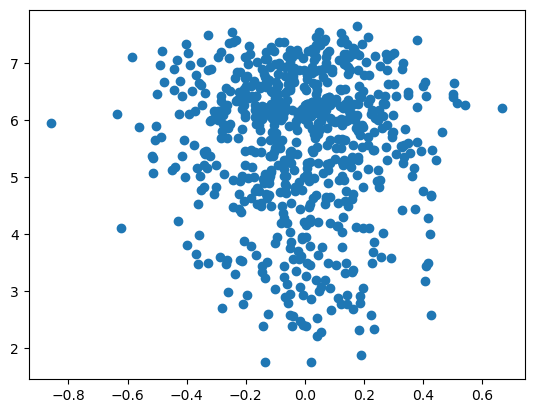

In [44]:
plt.scatter(mrl_bin2['log2FoldChange'], mrl_bin2['rl'])
r(mrl_bin2['log2FoldChange'], mrl_bin2['rl'])

In [45]:
scores = []
for pair in zip(mrl_bin3['seq'],mrl_bin3['utr']):
    score = aligner.score(pair[0], pair[1])
    scores.append(score)

mrl_bin3['nw_score'] = scores
mrl_bin3 = mrl_bin3[mrl_bin3['nw_score'] >= 40]

-0.0335

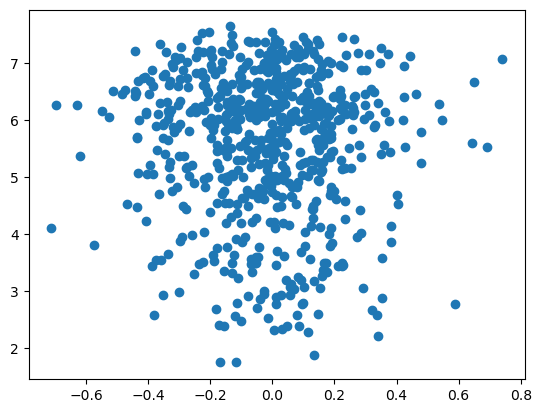

In [46]:
plt.scatter(mrl_bin3['log2FoldChange'], mrl_bin3['rl'])
r(mrl_bin3['log2FoldChange'], mrl_bin3['rl'])

**Results** Even for Sequences which were matched via transcript ID, that align perfectly, there is no correlation between MRL and log2FC. So log2FC cannot be predicted using the OptMRL model.

Why?

In [39]:
print(nw(mrl_bin2['seq'][125], mrl_bin2['utr'][125]))

CATCTTGCGAGCTCGTCGTACTGACCGAGCGGGGAGGCTGTCTTGAGGCGGCACCGCTCACCGACACCGAGGCGGACTGGCAGCCCTGAGCGTCGCAGTC
--------------------------------------------------GCACCGCTCACCGACACCGAGGCGGACTGGCAGCCCTGAGCGTCGCAGTC


In [40]:
print(nw(mrl_bin2['seq'][10], mrl_bin2['utr'][10]))

GGGAGCTTTGGGAGGGGGCGGGAATTCCCGACTCTAGGCCGGAAGCGCGCGGAGACCTTGTAGTGAGACCCTCGCGAGGTCTGAGAGTCACTGGAGC-TAC
--TAG---T--GA--------G-A---CC--CTC---G-C-G-A-------G-G-TC-TG-A--GAGTCACT-G-GA-G-CT---A--C-CAGAAGCAT-C


In [51]:
bin3[bin3.padj <0.4]

,UTR ID,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
3,8312,1802.15706,-0.885625,0.212867,-4.160453,0.000032,0.370087
